In [3]:
import cv2
import torch
import os
from ultralytics import YOLO

# Load the trained YOLOv11 model with best weights
model = YOLO("best.pt")  # Update with your actual model path

# Define input and output folders
input_folder = "Phone"  # Folder containing test images
output_folder = "output_images"  # Folder to save processed images
os.makedirs(output_folder, exist_ok=True)

# Define text properties
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (0, 255, 0)  # Green text
thickness = 2

total_objects_detected = 0

# Loop through all images in the input folder
for image_name in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_name)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping {image_name}: Unable to read image.")
        continue

    # Resize image to 640x640 before inference
    image = cv2.resize(image, (640, 640))

    # Perform object detection
    results = model(image)
    detections = results[0].boxes
    num_objects = len(detections)
    total_objects_detected += num_objects

    # Loop through detections and draw bounding boxes
    for box in detections:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
        conf = box.conf[0].item()  # Confidence score
        label = f"NLB  {conf:.2f}"  # Class label with confidence

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Put label above the bounding box
        cv2.putText(image, label, (x1, y1 - 10), font, 0.5, (0, 255, 0), thickness)

    # Display the number of objects detected on the image
    text = f"Objects Detected: {num_objects}"
    cv2.putText(image, text, (50, 50), font, font_scale, font_color, thickness)

    # Save the processed image
    output_path = os.path.join(output_folder, image_name)
    cv2.imwrite(output_path, image)
    print(f"Processed {image_name}: {num_objects} objects detected")

print(f"Total objects detected across all images: {total_objects_detected}")
print("Inference completed for all images.")


0: 640x640 1 Northern-Corn-Leaf-Blight, 94.4ms
Speed: 4.6ms preprocess, 94.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)
Processed IMG_20250311_142056_731.jpg: 1 objects detected

0: 640x640 6 Northern-Corn-Leaf-Blights, 73.3ms
Speed: 1.7ms preprocess, 73.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Processed IMG_20250311_143349_908.jpg: 6 objects detected

0: 640x640 5 Northern-Corn-Leaf-Blights, 67.2ms
Speed: 1.1ms preprocess, 67.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Processed IMG_20250311_141621_720.jpg: 5 objects detected

0: 640x640 3 Northern-Corn-Leaf-Blights, 66.6ms
Speed: 1.3ms preprocess, 66.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Processed IMG_20250311_142145_492.jpg: 3 objects detected

0: 640x640 10 Northern-Corn-Leaf-Blights, 64.0ms
Speed: 1.1ms preprocess, 64.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Processed IMG_20250311_103125_592.jpg:

In [16]:
import cv2
import torch
import tkinter as tk
from tkinter import Label, Button
from ultralytics import YOLO
from PIL import Image, ImageTk
import numpy as np
import os
from datetime import datetime

# Load YOLOv8 model
MODEL_PATH = "best.pt"
model = YOLO(MODEL_PATH)

# Create output folder
os.makedirs("inference_test", exist_ok=True)

# Initialize Tkinter
root = tk.Tk()
root.title("YOLOv8  NBL Detection")
root.geometry("1280x850")  # Full HD layout

# Capture webcam
cap = cv2.VideoCapture(0)

# ========== Layout Setup ==========
# Top frame (for previews)
top_frame = tk.Frame(root)
top_frame.pack(fill=tk.BOTH, expand=True)

# Bottom frame (for button)1
bottom_frame = tk.Frame(root, height=200)
bottom_frame.pack(fill=tk.X)

# Left frame for live camera preview
left_frame = tk.Frame(top_frame, width=750, height=750 ,)
left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# Right frame for inference result
right_frame = tk.Frame(top_frame, width=750, height=750,)
right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

# Label widgets for camera and inference previews
camera_label = Label(left_frame)
camera_label.pack(expand=True)

inference_label = Label(right_frame)
inference_label.pack(expand=True)

# Capture button
capture_button = Button(
    bottom_frame,
    text="Capture & Inference",
    command=lambda: capture_and_infer(),
    font=("Arial", 35),
    padx=20,
    pady=5
)
capture_button.pack(pady=10)

# Global to store latest frame
latest_frame = None

# ========== Video Loop ==========
def update_video():
    global latest_frame
    ret, frame = cap.read()
    if ret:
        latest_frame = frame.copy()
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(cv2.resize(rgb, (750,750)))
        imgtk = ImageTk.PhotoImage(image=img)
        camera_label.imgtk = imgtk
        camera_label.configure(image=imgtk)
    root.after(10, update_video)

# ========== Inference & Save ==========
def capture_and_infer():
    global latest_frame
    if latest_frame is None:
        return

    frame = latest_frame.copy()
    results = model(frame)

    # Draw detection and count
    for result in results:
        detected_img = result.plot()
        count = len(result.boxes)

    # Annotate number of objects
    cv2.putText(
        detected_img,
        f"North Leaf Blind detected: {count}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )

    # Save with timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_path = f"inference_test/inference_{timestamp}.jpg"
    cv2.imwrite(save_path, detected_img)

    # Show in inference panel
    img_rgb = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(cv2.resize(img_rgb, (750,750 )))
    imgtk = ImageTk.PhotoImage(image=img_pil)
    inference_label.imgtk = imgtk
    inference_label.configure(image=imgtk)

def on_closing():
    print("Closing the app safely...")
    cap.release()
    cv2.destroyAllWindows()
    root.destroy()

# Handle window close event
root.protocol("WM_DELETE_WINDOW", on_closing)


# Start loop
update_video()
root.mainloop()

# Cleanup
cap.release()
cv2.destroyAllWindows()



0: 384x640 1 Northern-Corn-Leaf-Blight, 55.7ms
Speed: 2.2ms preprocess, 55.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Closing the app safely...


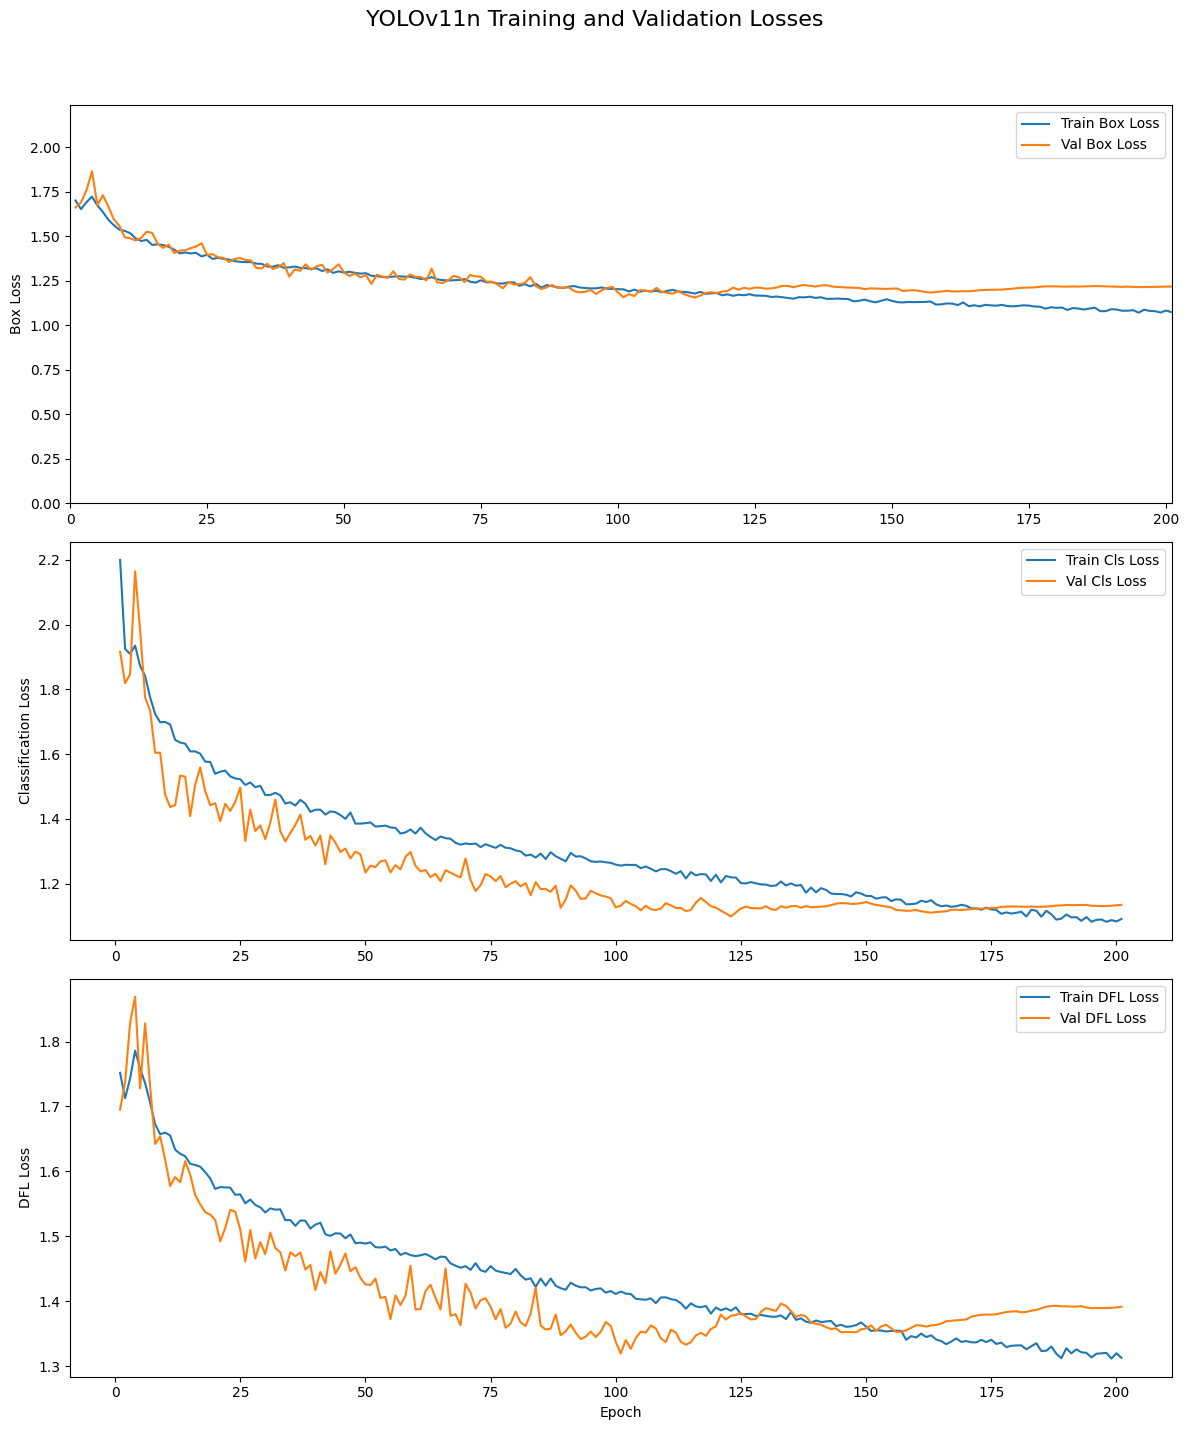

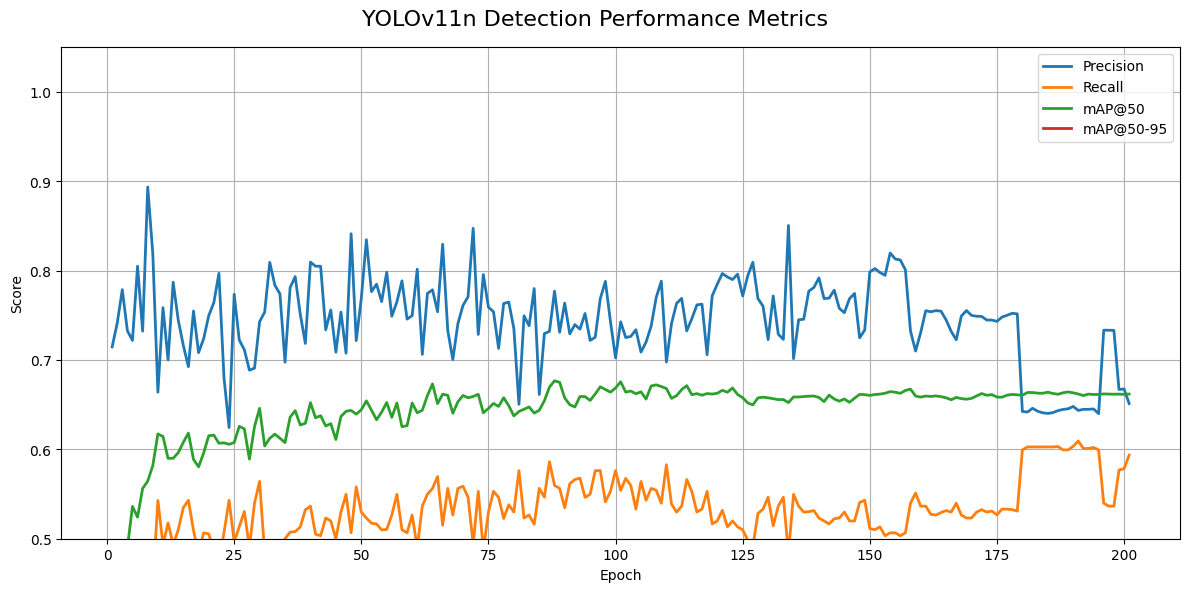

In [1]:


import pandas as pd
import matplotlib.pyplot as plt

# Load actual training results from YOLOv11n (Ultralytics format)
df = pd.read_csv("results.csv")

# Set up subplots for losses
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle('YOLOv11n Training and Validation Losses', fontsize=16)

# Plot box loss
axes[0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
axes[0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0].set_ylabel('Box Loss')
axes[0].legend()
max_box_loss = max(df['train/box_loss'].max(), df['val/box_loss'].max())
axes[0].set_ylim(0, max_box_loss * 1.2)
axes[0].set_xlim(0, df['epoch'].max())

# Plot classification loss
axes[1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
axes[1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[1].set_ylabel('Classification Loss')
axes[1].legend()

# Plot DFL loss
axes[2].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
axes[2].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
axes[2].set_ylabel('DFL Loss')
axes[2].set_xlabel('Epoch')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot performance metrics
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('YOLOv11n Detection Performance Metrics', fontsize=16)

ax.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2)
ax.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2)
ax.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', linewidth=2)
ax.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_ylim(0.5, 1.05)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   epoch                 201 non-null    int64  
 1   time                  201 non-null    float64
 2   train/box_loss        201 non-null    float64
 3   train/cls_loss        201 non-null    float64
 4   train/dfl_loss        201 non-null    float64
 5   metrics/precision(B)  201 non-null    float64
 6   metrics/recall(B)     201 non-null    float64
 7   metrics/mAP50(B)      201 non-null    float64
 8   metrics/mAP50-95(B)   201 non-null    float64
 9   val/box_loss          201 non-null    float64
 10  val/cls_loss          201 non-null    float64
 11  val/dfl_loss          201 non-null    float64
 12  lr/pg0                201 non-null    float64
 13  lr/pg1                201 non-null    float64
 14  lr/pg2                201 non-null    float64
dtypes: float64(14), int64(1

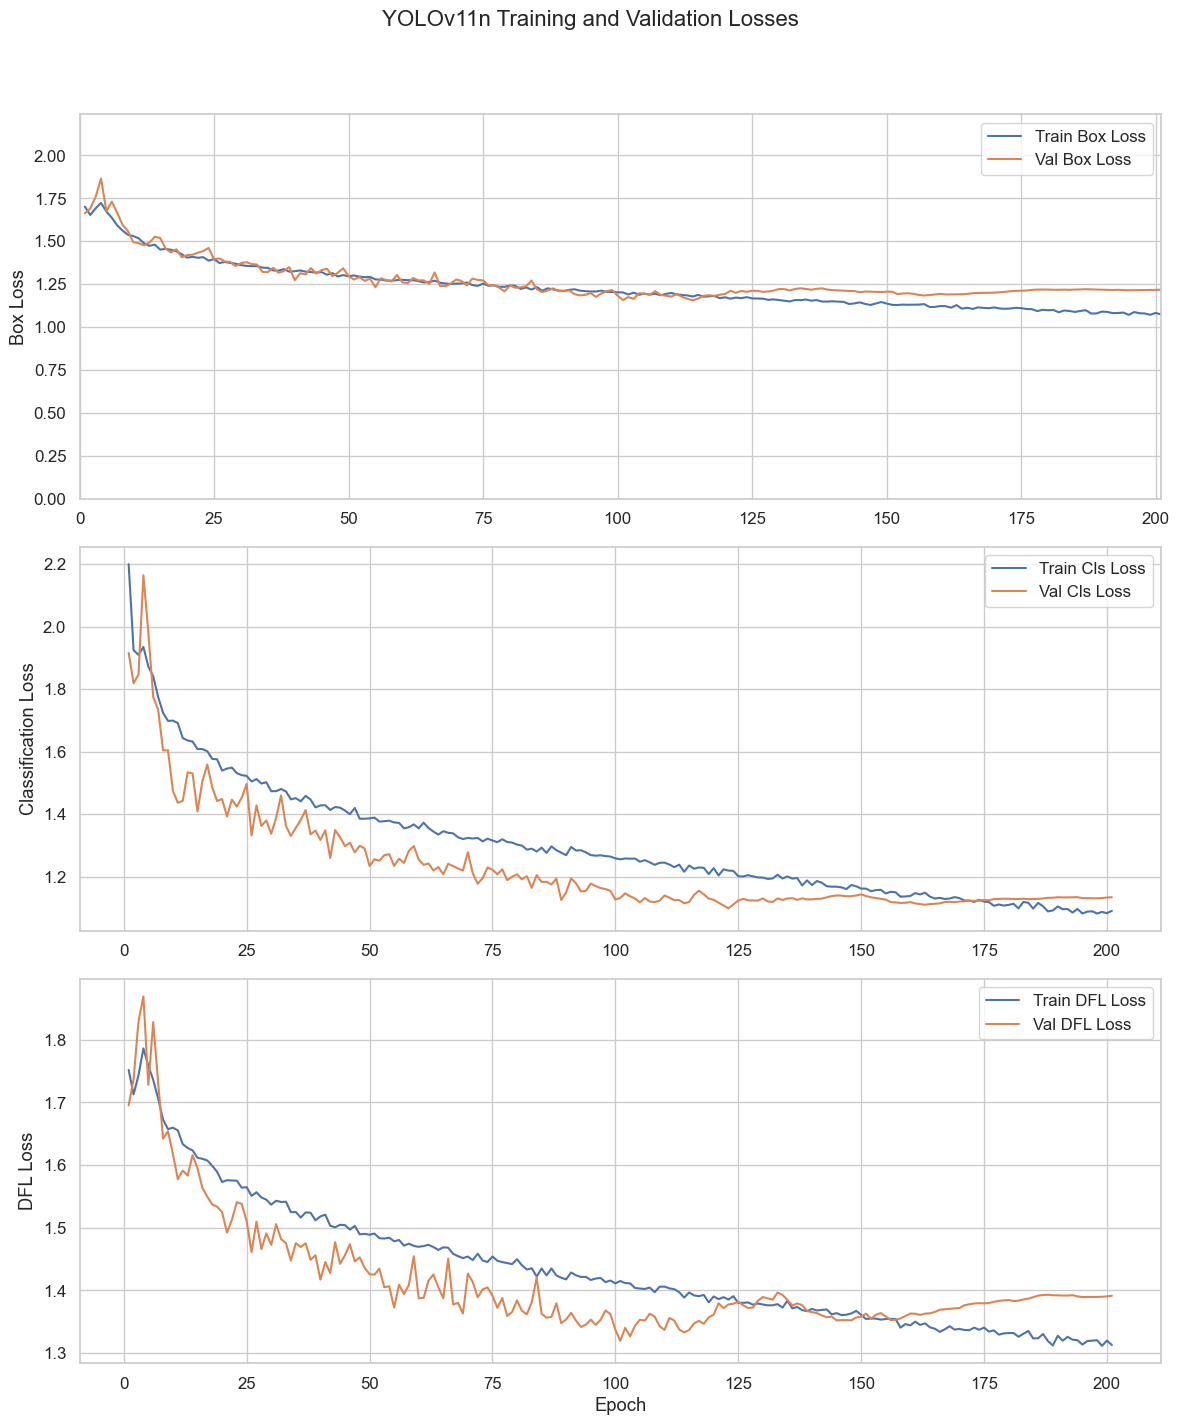

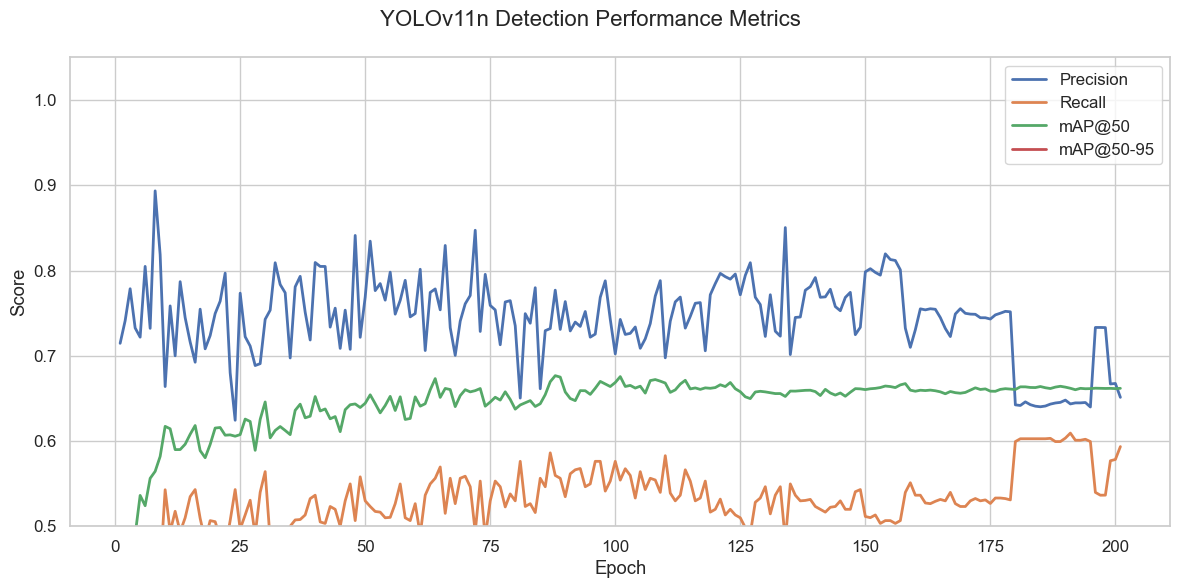

{'Epoch': 101,
 'Precision': 0.74261,
 'Recall': 0.55412,
 'mAP@50': 0.67555,
 'mAP@50-95': 0.46553,
 'Val Box Loss': 1.15755,
 'Val Cls Loss': 1.13199,
 'Val DFL Loss': 1.31943}

In [3]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'results.csv'
df = pd.read_csv(file_path)

# Display basic info and first few rows to understand the structure
df.info(), df.head()


import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="deep", font_scale=1.1)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle('YOLOv11n Training and Validation Losses', fontsize=16)

# Plot losses
axes[0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
axes[0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0].set_ylabel('Box Loss')
axes[0].legend()

# Dynamically extend y-axis scale
max_loss = max(df['train/box_loss'].max(), df['val/box_loss'].max())
axes[0].set_ylim(0, max_loss * 1.2)  # Extend 20% above the maximum loss

# Optionally adjust x-axis to match epochs
axes[0].set_xlim(0, df['epoch'].max())


axes[1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
axes[1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[1].set_ylabel('Classification Loss')
axes[1].legend()

axes[2].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
axes[2].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
axes[2].set_ylabel('DFL Loss')
axes[2].set_xlabel('Epoch')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot Precision, Recall, and mAP over Epochs
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('YOLOv11n Detection Performance Metrics', fontsize=16)

ax.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2)
ax.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2)
ax.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', linewidth=2)
ax.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_ylim(0.5, 1.05)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the best epoch based on highest mAP@50-95
best_epoch_idx = df['metrics/mAP50-95(B)'].idxmax()
best_epoch_data = df.loc[best_epoch_idx]

# Extract key values
best_epoch = int(best_epoch_data['epoch'])
best_metrics = {
    'Epoch': best_epoch,
    'Precision': best_epoch_data['metrics/precision(B)'],
    'Recall': best_epoch_data['metrics/recall(B)'],
    'mAP@50': best_epoch_data['metrics/mAP50(B)'],
    'mAP@50-95': best_epoch_data['metrics/mAP50-95(B)'],
    'Val Box Loss': best_epoch_data['val/box_loss'],
    'Val Cls Loss': best_epoch_data['val/cls_loss'],
    'Val DFL Loss': best_epoch_data['val/dfl_loss']
}

best_metrics
